## Table of Contents

1. [Objective](#section1)<br> 
2. [Importing Python Libraries](#section2)<br> 
3. [Establishing Connection with MongoDB and Loading JSON File](#section3)<br> 
4. [Storing the MongoDB Collection Data in a Dataframe ](#section4)<br> 
5. [Data Processing](#section5)<br>
    - 5.1 [Removing Meta-Data Columns](#section50101)<br>     
    - 5.2 [Type-casting Date and State Variable into Date and String Datatype](#section50102)<br>
    - 5.3 [Split Geostate Code to Extract Longitude and Latitude](#section50103)<br> 
    - 5.4 [Treatment of Columns with Missing Values](#section50104)<br>
    - 5.5 [Retrieve State Description from Lookup CSV file](#section50105)<br>
    - 5.6 [Writing the new dataframe into a CSV file with all the data operations and modifications](#section50106)<br>      
6. [Establish connection with PostgreSQL, Create Database and Table Schema](#section6) <br>
7. [Visualization and Data Preparation](#section7)

<a id=section1></a>
## Objective
The end-objective is to evaluate the impact of COVID-19 on hsopitals across United States during the period of March-2020 to March 2021. We can intricately analyze the parameters like COVID Admissions, Critical Staff Shortage , Inpatient Beds, ICU occupancy, Adult and Pediatric Bifurcations across different states.   

<a id=section2></a>
## 2. Importing Python Libraries

In [32]:
# Importing Required Python Libraries
import json
from pymongo import MongoClient
import pandas as pd
import numpy as np
import os
import fuzzymatcher
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import plotly.express as px
import seaborn as sns
import pandas.io.sql as sqlio
import psycopg2

<a id=section3></a>
## 3. Establishing Connection with MongoDB and Loading JSON File

In [33]:
#Establishing Connection with Mongo Server
try:
    client = MongoClient('localhost', 27017)
    print("Connected!")
except:
    print("Unable to connect to MongoDB instance")

Connected!


In [34]:
# Setting up the working directory
#os.chdir('/Users/adityaraj/Desktop/Database and Analytics Programming Folder/CA Project/')
#Opening the COVID JSON File and reading the data and storing the data within the defined Collection Name
try:
    with open('COVID-19 Reported Patient Impact and Hospital Capacity by State Timeseries.json') as f:
        file_data = json.load(f)
except FileNotFoundError:
    print("File not found at the location")
except:
    print("Error in Processing File")
client.close()

In [35]:
#Creating an instance on MongoDB and initializing DB and connection parameters, Inserting a file into the New collection

db = client['COVID']
collection_covid = db['COVID_HOSPITAL']

try:
    collection_covid.insert_one(file_data) #Inserting the loaded json file in line 2 to MongoDB
    print("Connection Successful!")
except:
    collection_covid.insert(file_data) #Inserting the loaded json file in line 2 to MongoDB
    print("Connection Successful!")
    #print("Unable to Connect to MongoDB")


client.close()

In [36]:
#Extracting Column Names from the Columns tag within JSON file and storing into a 'cols' list

getData = pd.DataFrame(list(collection_covid.find())) 
cols = []

for data in getData["meta"]:
    for column in data['view']['columns']:
        columnName = column['name']
        if columnName not in cols:
            cols.append(columnName)
        
print(cols)

['sid', 'id', 'position', 'created_at', 'created_meta', 'updated_at', 'updated_meta', 'meta', 'state', 'date', 'critical_staffing_shortage_today_yes', 'critical_staffing_shortage_today_no', 'critical_staffing_shortage_today_not_reported', 'critical_staffing_shortage_anticipated_within_week_yes', 'critical_staffing_shortage_anticipated_within_week_no', 'critical_staffing_shortage_anticipated_within_week_not_reported', 'hospital_onset_covid', 'hospital_onset_covid_coverage', 'inpatient_beds', 'inpatient_beds_coverage', 'inpatient_beds_used', 'inpatient_beds_used_coverage', 'inpatient_beds_used_covid', 'inpatient_beds_used_covid_coverage', 'previous_day_admission_adult_covid_confirmed', 'previous_day_admission_adult_covid_confirmed_coverage', 'previous_day_admission_adult_covid_suspected', 'previous_day_admission_adult_covid_suspected_coverage', 'previous_day_admission_pediatric_covid_confirmed', 'previous_day_admission_pediatric_covid_confirmed_coverage', 'previous_day_admission_pediatri

<a id=section4></a>
## 4. Storing the MongoDB Collection Data in a Dataframe

In [37]:
#Store the data into a dataframe and use "cols" list as column names in the dataframe
COVID_HOSPITAL = pd.DataFrame(getData["data"][0], columns = cols)
COVID_HOSPITAL.head()

,sid,id,position,created_at,created_meta,updated_at,updated_meta,meta,state,date,...,inpatient_bed_covid_utilization_denominator,adult_icu_bed_covid_utilization,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_covid_utilization_numerator,adult_icu_bed_covid_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator,geocoded_state
0,row-2ws6~7xbg-x7td,00000000-0000-0000-96B1-2F449842D794,0,1616853107,None,1616853107,None,{ },IA,2021-01-03T00:00:00,...,8024,0.17835365853658536,124,117,656,0.68,126,459,675,POINT (-93.500061 42.074659)
1,row-9hxe~53ka~ex4u,00000000-0000-0000-9F29-CA9CC62C6CAA,0,1616853107,None,1616853107,None,{ },ID,2021-01-03T00:00:00,...,3644,0.23178807947019867,51,70,302,0.6245954692556634,52,193,309,POINT (-114.659366 44.389073)
2,row-8irx.ii9u_yemm,00000000-0000-0000-E2CD-4B54EBD757E5,0,1616853107,None,1616853107,None,{ },IL,2021-01-03T00:00:00,...,32079,0.22763532763532762,202,799,3510,0.6284596030192899,207,2248,3577,POINT (-89.148632 40.124144)
3,row-dvbe_iika-mmc2,00000000-0000-0000-DDE2-94A11162072C,0,1616853107,None,1616853107,None,{ },IN,2021-01-03T00:00:00,...,18456,0.2989206945096199,164,637,2131,0.7408256880733946,166,1615,2180,POINT (-86.2818 39.919991)
4,row-38b6_nv3m~rijp,00000000-0000-0000-7AD5-E5DB09B972BF,0,1616853107,None,1616853107,None,{ },KS,2021-01-03T00:00:00,...,8738,0.31966224366706875,147,265,829,0.7403055229142186,150,630,851,POINT (-98.38018 38.484729)


<a id=section5></a>
## 5. Data Preprocessing

<a id=section50101></a>
## 5.1. Removing Meta-Data Columns

In [38]:
#We have first 8 columns related to META data, we can drop these columns from our COVID_HOSPITAL dataframe

COVID_HOSPITAL.drop(COVID_HOSPITAL.columns[0:8], axis = 1, inplace = True)
COVID_HOSPITAL.head()
# COVID_HOSPITAL.info()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,inpatient_bed_covid_utilization_denominator,adult_icu_bed_covid_utilization,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_covid_utilization_numerator,adult_icu_bed_covid_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator,geocoded_state
0,IA,2021-01-03T00:00:00,6,63,57,6,62,58,2,124,...,8024,0.17835365853658536,124,117,656,0.68,126,459,675,POINT (-93.500061 42.074659)
1,ID,2021-01-03T00:00:00,4,47,1,7,44,1,5,51,...,3644,0.23178807947019867,51,70,302,0.6245954692556634,52,193,309,POINT (-114.659366 44.389073)
2,IL,2021-01-03T00:00:00,19,171,17,17,173,17,73,202,...,32079,0.22763532763532762,202,799,3510,0.6284596030192899,207,2248,3577,POINT (-89.148632 40.124144)
3,IN,2021-01-03T00:00:00,22,142,2,29,135,2,9,164,...,18456,0.2989206945096199,164,637,2131,0.7408256880733946,166,1615,2180,POINT (-86.2818 39.919991)
4,KS,2021-01-03T00:00:00,10,136,4,13,133,4,14,147,...,8738,0.31966224366706875,147,265,829,0.7403055229142186,150,630,851,POINT (-98.38018 38.484729)


<a id=section50102></a>
## 5.2. Type-casting Date and State Variable into Date and String Datatype

In [39]:
# Changing the datatype of date and state column to date and string
COVID_HOSPITAL['date']= pd.to_datetime(COVID_HOSPITAL['date'])
COVID_HOSPITAL['state']=COVID_HOSPITAL['state'].astype(str)

<a id=section50103></a>
## 5.3. Split Geostate Code to Extract Longitude and Latitude

In [40]:
#Bifurcating GEOCODED_STATE into two different columns LATITUDE and LONGITUDE

# Creating two empty lists for storing Latitude and Longitude traversing through each row in the dataframe
lat = []
lon = []

# For each row in a COVID_HOSPITAL,
for row in COVID_HOSPITAL['geocoded_state']:
    # Using TRY Block,
    try:
        # Split the row by space ' ' and strip the bracket from the output and append
        lat.append(row.split(' ')[1].strip("("))
        # Split the row by space ' ' and strip the bracket from the output and append
        lon.append(row.split(' ')[2].strip(")"))
    # Handling Error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
COVID_HOSPITAL['latitude'] = lat
COVID_HOSPITAL['longitude'] = lon
COVID_HOSPITAL.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_covid_utilization_numerator,adult_icu_bed_covid_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator,geocoded_state,latitude,longitude
0,IA,2021-01-03,6,63,57,6,62,58,2,124,...,124,117,656,0.68,126,459,675,POINT (-93.500061 42.074659),-93.500061,42.074659
1,ID,2021-01-03,4,47,1,7,44,1,5,51,...,51,70,302,0.6245954692556634,52,193,309,POINT (-114.659366 44.389073),-114.659366,44.389073
2,IL,2021-01-03,19,171,17,17,173,17,73,202,...,202,799,3510,0.6284596030192899,207,2248,3577,POINT (-89.148632 40.124144),-89.148632,40.124144
3,IN,2021-01-03,22,142,2,29,135,2,9,164,...,164,637,2131,0.7408256880733946,166,1615,2180,POINT (-86.2818 39.919991),-86.2818,39.919991
4,KS,2021-01-03,10,136,4,13,133,4,14,147,...,147,265,829,0.7403055229142186,150,630,851,POINT (-98.38018 38.484729),-98.38018,38.484729


<a id=section50104></a>
## 5.4. Treatment of Columns with Missing Values

In [41]:
# Extracting the Number of columns which NULL values and its magnitude
# Storing the list 
missing=[]
# Checking columns in the dataframe that have more than 5000 Null Values
missing.append(COVID_HOSPITAL.columns[COVID_HOSPITAL.isna().sum()>5000])
print(missing)

# Using the column names extracted to drop from the dataframe
COVID_HOSPITAL.drop(['previous_day_admission_adult_covid_confirmed',
       'previous_day_admission_adult_covid_suspected',
       'previous_day_admission_pediatric_covid_confirmed',
       'previous_day_admission_pediatric_covid_suspected',
       'staffed_adult_icu_bed_occupancy',
       'staffed_icu_adult_patients_confirmed_and_suspected_covid',
       'staffed_icu_adult_patients_confirmed_covid',
       'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid',
       'total_pediatric_patients_hospitalized_confirmed_covid',
       'total_staffed_adult_icu_beds', 'adult_icu_bed_covid_utilization',
       'adult_icu_bed_covid_utilization_coverage',
       'adult_icu_bed_covid_utilization_numerator',
       'adult_icu_bed_covid_utilization_denominator',
       'adult_icu_bed_utilization', 'adult_icu_bed_utilization_coverage',
       'adult_icu_bed_utilization_numerator',
       'adult_icu_bed_utilization_denominator',
       'total_adult_patients_hospitalized_confirmed_and_suspected_covid', 
       'total_adult_patients_hospitalized_confirmed_covid'], axis = 1, inplace = True)



[Index(['previous_day_admission_adult_covid_confirmed',
       'previous_day_admission_adult_covid_suspected',
       'previous_day_admission_pediatric_covid_confirmed',
       'previous_day_admission_pediatric_covid_suspected',
       'staffed_adult_icu_bed_occupancy',
       'staffed_icu_adult_patients_confirmed_and_suspected_covid',
       'staffed_icu_adult_patients_confirmed_covid',
       'total_adult_patients_hospitalized_confirmed_and_suspected_covid',
       'total_adult_patients_hospitalized_confirmed_covid',
       'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid',
       'total_pediatric_patients_hospitalized_confirmed_covid',
       'total_staffed_adult_icu_beds', 'adult_icu_bed_covid_utilization',
       'adult_icu_bed_covid_utilization_coverage',
       'adult_icu_bed_covid_utilization_numerator',
       'adult_icu_bed_covid_utilization_denominator',
       'adult_icu_bed_utilization', 'adult_icu_bed_utilization_coverage',
       'adult_icu_bed_utiliz

In [42]:
COVID_HOSPITAL.info()
COVID_HOSPITAL.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17508 entries, 0 to 17507
Data columns (total 43 columns):
 #   Column                                                                        Non-Null Count  Dtype         
---  ------                                                                        --------------  -----         
 0   state                                                                         17508 non-null  object        
 1   date                                                                          17508 non-null  datetime64[ns]
 2   critical_staffing_shortage_today_yes                                          17508 non-null  object        
 3   critical_staffing_shortage_today_no                                           17508 non-null  object        
 4   critical_staffing_shortage_today_not_reported                                 17508 non-null  object        
 5   critical_staffing_shortage_anticipated_within_week_yes                        17508 non-

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,percent_of_inpatients_with_covid_coverage,percent_of_inpatients_with_covid_numerator,percent_of_inpatients_with_covid_denominator,inpatient_bed_covid_utilization,inpatient_bed_covid_utilization_coverage,inpatient_bed_covid_utilization_numerator,inpatient_bed_covid_utilization_denominator,geocoded_state,latitude,longitude
0,IA,2021-01-03,6,63,57,6,62,58,2,124,...,124,594,4531,0.07402791625124626,124,594,8024,POINT (-93.500061 42.074659),-93.500061,42.074659
1,ID,2021-01-03,4,47,1,7,44,1,5,51,...,51,356,1941,0.09769484083424808,51,356,3644,POINT (-114.659366 44.389073),-114.659366,44.389073
2,IL,2021-01-03,19,171,17,17,173,17,73,202,...,202,4031,20611,0.12565853050282116,202,4031,32079,POINT (-89.148632 40.124144),-89.148632,40.124144
3,IN,2021-01-03,22,142,2,29,135,2,9,164,...,164,2817,11444,0.1526332899869961,164,2817,18456,POINT (-86.2818 39.919991),-86.2818,39.919991
4,KS,2021-01-03,10,136,4,13,133,4,14,147,...,147,1042,4940,0.11924925612268254,147,1042,8738,POINT (-98.38018 38.484729),-98.38018,38.484729


In [43]:
# Check Columns which have missing values
missing=COVID_HOSPITAL.isna().sum()
print(missing)

state                                                                             0
date                                                                              0
critical_staffing_shortage_today_yes                                              0
critical_staffing_shortage_today_no                                               0
critical_staffing_shortage_today_not_reported                                     0
critical_staffing_shortage_anticipated_within_week_yes                            0
critical_staffing_shortage_anticipated_within_week_no                             0
critical_staffing_shortage_anticipated_within_week_not_reported                   0
hospital_onset_covid                                                            168
hospital_onset_covid_coverage                                                     0
inpatient_beds                                                                    0
inpatient_beds_coverage                                                     

In [44]:
# Assigning Not Available in place of NULL values
COVID_HOSPITAL['hospital_onset_covid'].replace (np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['inpatient_beds_used'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['inpatient_beds_used_covid'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['inpatient_beds_utilization'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['inpatient_beds_utilization_coverage'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['inpatient_beds_utilization_numerator'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['inpatient_beds_utilization_denominator'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['percent_of_inpatients_with_covid'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['percent_of_inpatients_with_covid_coverage'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['percent_of_inpatients_with_covid_numerator'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['percent_of_inpatients_with_covid_denominator'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['inpatient_bed_covid_utilization'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['inpatient_bed_covid_utilization_coverage'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['inpatient_bed_covid_utilization_numerator'].replace(np.NaN, 'Not Available', inplace=True)
COVID_HOSPITAL['inpatient_bed_covid_utilization_denominator'].replace(np.NaN, 'Not Available', inplace=True)

In [45]:
# Assigning Mean Value to columns with value as 'Not Available'
COVID_HOSPITAL['hospital_onset_covid'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['hospital_onset_covid'][COVID_HOSPITAL['hospital_onset_covid']!='Not Available']).mean(), inplace=True)
COVID_HOSPITAL['inpatient_beds_used'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['inpatient_beds_used'][COVID_HOSPITAL['inpatient_beds_used']!='Not Available']).mean(), inplace=True)
COVID_HOSPITAL['inpatient_beds_used_covid'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['inpatient_beds_used_covid'][COVID_HOSPITAL['inpatient_beds_used_covid']!='Not Available']).mean(), inplace=True)
COVID_HOSPITAL['inpatient_beds_utilization'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['inpatient_beds_utilization'][COVID_HOSPITAL['inpatient_beds_utilization']!='Not Available']).mean(), inplace=True)
COVID_HOSPITAL['inpatient_beds_utilization_coverage'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['inpatient_beds_utilization_coverage'][COVID_HOSPITAL['inpatient_beds_utilization_coverage']!='Not Available']).mean(), inplace=True)
COVID_HOSPITAL['inpatient_beds_utilization_numerator'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['inpatient_beds_utilization_numerator'][COVID_HOSPITAL['inpatient_beds_utilization_numerator']!='Not Available']).mean(), inplace=True)
COVID_HOSPITAL['inpatient_beds_utilization_denominator'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['inpatient_beds_utilization_denominator'][COVID_HOSPITAL['inpatient_beds_utilization_denominator']!='Not Available']).mean(), inplace=True)
COVID_HOSPITAL['percent_of_inpatients_with_covid'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['percent_of_inpatients_with_covid'][COVID_HOSPITAL['percent_of_inpatients_with_covid']!='Not Available']).mean(), inplace=True)
COVID_HOSPITAL['percent_of_inpatients_with_covid_coverage'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['percent_of_inpatients_with_covid_coverage'][COVID_HOSPITAL['percent_of_inpatients_with_covid_coverage']!='Not Available']).mean(), inplace=True)
COVID_HOSPITAL['percent_of_inpatients_with_covid_numerator'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['percent_of_inpatients_with_covid_numerator'][COVID_HOSPITAL['percent_of_inpatients_with_covid_numerator']!='Not Available']).median(), inplace=True)
COVID_HOSPITAL['percent_of_inpatients_with_covid_denominator'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['percent_of_inpatients_with_covid_denominator'][COVID_HOSPITAL['percent_of_inpatients_with_covid_denominator']!='Not Available']).median(), inplace=True)
COVID_HOSPITAL['inpatient_bed_covid_utilization'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['inpatient_bed_covid_utilization'][COVID_HOSPITAL['inpatient_bed_covid_utilization']!='Not Available']).median(), inplace=True)
COVID_HOSPITAL['inpatient_bed_covid_utilization_coverage'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['inpatient_bed_covid_utilization_coverage'][COVID_HOSPITAL['inpatient_bed_covid_utilization_coverage']!='Not Available']).median(), inplace=True)
COVID_HOSPITAL['inpatient_bed_covid_utilization_numerator'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['inpatient_bed_covid_utilization_numerator'][COVID_HOSPITAL['inpatient_bed_covid_utilization_numerator']!='Not Available']).median(), inplace=True)
COVID_HOSPITAL['inpatient_bed_covid_utilization_denominator'].replace ('Not Available', pd.to_numeric(COVID_HOSPITAL['inpatient_bed_covid_utilization_denominator'][COVID_HOSPITAL['inpatient_bed_covid_utilization_denominator']!='Not Available']).median(), inplace=True)

In [46]:
#Check if we have any other columns with any missing values
missing=COVID_HOSPITAL.isna().sum()[COVID_HOSPITAL.isna().sum()>0]
print(missing)


Series([], dtype: int64)


<a id='section50105'></a>
## 5.5. Retrieve State Description from Lookup CSV file

In [47]:
states=pd.read_csv('states.csv')
states.head()

,State,Code
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [48]:
# Using Fuzzy Matcher 
left_on=['state']
right_on=['Code']
COVID = fuzzymatcher.fuzzy_left_join(COVID_HOSPITAL,
                                            states,
                                            left_on,
                                            right_on,
                                            left_id_col='state',
                                            right_id_col='Code')

COVID.drop(['best_match_score','__id_left','__id_right','Code'], axis = 1, inplace = True)
COVID.rename(columns={'State':'state_desc'}, inplace=True)
COVID.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,percent_of_inpatients_with_covid_numerator,percent_of_inpatients_with_covid_denominator,inpatient_bed_covid_utilization,inpatient_bed_covid_utilization_coverage,inpatient_bed_covid_utilization_numerator,inpatient_bed_covid_utilization_denominator,geocoded_state,latitude,longitude,state_desc
0,IA,2021-01-03,6,63,57,6,62,58,2,124,...,594,4531,0.07402791625124626,124,594,8024,POINT (-93.500061 42.074659),-93.500061,42.074659,Iowa
1,ID,2021-01-03,4,47,1,7,44,1,5,51,...,356,1941,0.09769484083424808,51,356,3644,POINT (-114.659366 44.389073),-114.659366,44.389073,Idaho
2,IL,2021-01-03,19,171,17,17,173,17,73,202,...,4031,20611,0.12565853050282116,202,4031,32079,POINT (-89.148632 40.124144),-89.148632,40.124144,Illinois
3,IN,2021-01-03,22,142,2,29,135,2,9,164,...,2817,11444,0.1526332899869961,164,2817,18456,POINT (-86.2818 39.919991),-86.2818,39.919991,Indiana
4,KS,2021-01-03,10,136,4,13,133,4,14,147,...,1042,4940,0.11924925612268254,147,1042,8738,POINT (-98.38018 38.484729),-98.38018,38.484729,Kansas


<a id='section50106'></a>
## 5.6. Writing the new dataframe into a CSV file with all the data operations and modifications

In [49]:
# Writing the new dataframe into a CSV file with all the data operations

COVID.to_csv(r'COVID-19 Reported Patient Impact and Hospital Capacity by State Timeseries.csv',index=False)

<a id=section6></a>
## 6. Establish connection with PostgreSQL, Create Database and Table Schema


In [50]:

try:
    dbConnection = psycopg2.connect(user = "postgres",password = "abcd1234",host = "localhost",port = "5432")
    print("Connected!")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute('CREATE DATABASE covid;')
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()


Connected!
Error while connecting to PostgreSQL database "covid" already exists



In [51]:
createString="""

CREATE TABLE COVID_HOSPITAL (
state	varchar	,
date	date	,
critical_staffing_shortage_today_yes	float	,
critical_staffing_shortage_today_no	float	,
critical_staffing_shortage_today_not_reported	float	,
critical_staffing_shortage_anticipated_within_week_yes	float	,
critical_staffing_shortage_anticipated_within_week_no	float	,
critical_staffing_shortage_anticipated_within_week_not_reported	float	,
hospital_onset_covid	float	,
hospital_onset_covid_coverage	float	,
inpatient_beds	float	,
inpatient_beds_coverage	float	,
inpatient_beds_used	float	,
inpatient_beds_used_coverage	float	,
inpatient_beds_used_covid	float	,
inpatient_beds_used_covid_coverage	float	,
previous_day_admission_adult_covid_confirmed_coverage	float	,
previous_day_admission_adult_covid_suspected_coverage	float	,
previous_day_admission_pediatric_covid_confirmed_coverage	float	,
previous_day_admission_pediatric_covid_suspected_coverage	float	,
staffed_adult_icu_bed_occupancy_coverage	float	,
staffed_icu_adult_patients_conf_and_sus_covid_coverage	float	,
staffed_icu_adult_patients_confirmed_covid_coverage	float	,
total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage	float	,
total_adult_patients_hospitalized_confirmed_covid_coverage	float	,
total_pediatric_patients_hospital_conf_and_sus_covid_coverage	float	,
total_pediatric_patients_hospitalized_confirmed_covid_coverage	float	,
total_staffed_adult_icu_beds_coverage	float	,
inpatient_beds_utilization	float	,
inpatient_beds_utilization_coverage	float	,
inpatient_beds_utilization_numerator	float	,
inpatient_beds_utilization_denominator	float	,
percent_of_inpatients_with_covid	float	,
percent_of_inpatients_with_covid_coverage	float	,
percent_of_inpatients_with_covid_numerator	float	,
percent_of_inpatients_with_covid_denominator	float	,
inpatient_bed_covid_utilization	float	,
inpatient_bed_covid_utilization_coverage	float	,
inpatient_bed_covid_utilization_numerator	float	,
inpatient_bed_covid_utilization_denominator	float	,
geocoded_state	varchar	,
latitude	float	,
longitude	float	,
state_desc varchar
);
"""

In [52]:
try:
    dbConnection = psycopg2.connect(user = "postgres",password = "abcd1234",host = "localhost",port = "5432",database = "coviddb")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(createString)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

Error while connecting to PostgreSQL relation "covid_hospital" already exists



In [53]:
try:
    dbConnection = psycopg2.connect(user = "postgres",password = "abcd1234",host = "localhost",port = "5432",database = "coviddb")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    # dbCursor = dbConnection.cursor()
    sql = "COPY %s FROM STDIN WITH CSV HEADER DELIMITER AS ','"
    file = open("/Users/adityaraj/Desktop/Database and Analytics Programming Folder/CA Project/COVID-19 Reported Patient Impact and Hospital Capacity by State Timeseries.csv", "r")
    #Inserting data from merged CSV into table in Postgres
    with dbConnection.cursor() as cur:

        #Avoiding uploading duplicate data!
        cur.execute("truncate " + "covid_hospital" + ";")
        cur.copy_expert(sql=sql % "covid_hospital", file=file)
        dbConnection.commit()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [54]:
#Fetch Data

sql = """SELECT * FROM covid_hospital;"""
try:
    dbConnection = psycopg2.connect(user = "postgres",password = "abcd1234",host = "localhost",port = "5432",database = "coviddb")
    covid_dataframe = sqlio.read_sql_query(sql, dbConnection)
    print(covid_dataframe)
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

      state        date  critical_staffing_shortage_today_yes  \
0        IA  2021-01-03                                   6.0   
1        ID  2021-01-03                                   4.0   
2        IL  2021-01-03                                  19.0   
3        IN  2021-01-03                                  22.0   
4        KS  2021-01-03                                  10.0   
...     ...         ...                                   ...   
17503    NJ  2020-09-21                                  11.0   
17504    NM  2020-09-21                                  13.0   
17505    NV  2020-09-21                                   4.0   
17506    NY  2020-09-21                                   9.0   
17507    OH  2020-09-21                                   9.0   

       critical_staffing_shortage_today_no  \
0                                     63.0   
1                                     47.0   
2                                    171.0   
3                                  

<a id=section7></a>
## 7. Visualization

In [55]:
#Data Preparation for Visualizations
# Changing Columns into Numeric for using in Visualizations
covid_dataframe['critical_staffing_shortage_today_yes']=pd.to_numeric(covid_dataframe['critical_staffing_shortage_today_yes'])
covid_dataframe['critical_staffing_shortage_today_no']=pd.to_numeric(covid_dataframe['critical_staffing_shortage_today_no'])
covid_dataframe['critical_staffing_shortage_today_not_reported']=pd.to_numeric(covid_dataframe['critical_staffing_shortage_today_not_reported'])
covid_dataframe['critical_staffing_shortage_anticipated_within_week_yes']=pd.to_numeric(covid_dataframe['critical_staffing_shortage_anticipated_within_week_yes'])
covid_dataframe['critical_staffing_shortage_anticipated_within_week_no']=pd.to_numeric(covid_dataframe['critical_staffing_shortage_anticipated_within_week_no'])
covid_dataframe['critical_staffing_shortage_anticipated_within_week_not_reported']=pd.to_numeric(covid_dataframe['critical_staffing_shortage_anticipated_within_week_not_reported'])
covid_dataframe['hospital_onset_covid']=pd.to_numeric(covid_dataframe['hospital_onset_covid'])
covid_dataframe['hospital_onset_covid_coverage']=pd.to_numeric(covid_dataframe['hospital_onset_covid_coverage'])
covid_dataframe['inpatient_beds']=pd.to_numeric(covid_dataframe['inpatient_beds'])
covid_dataframe['inpatient_beds_coverage']=pd.to_numeric(covid_dataframe['inpatient_beds_coverage'])
covid_dataframe['inpatient_beds_used']=pd.to_numeric(covid_dataframe['inpatient_beds_used'])
covid_dataframe['inpatient_beds_used_coverage']=pd.to_numeric(covid_dataframe['inpatient_beds_used_coverage'])
covid_dataframe['inpatient_beds_used_covid']=pd.to_numeric(covid_dataframe['inpatient_beds_used_covid'])
covid_dataframe['inpatient_beds_used_covid_coverage']=pd.to_numeric(covid_dataframe['inpatient_beds_used_covid_coverage'])
covid_dataframe['previous_day_admission_adult_covid_confirmed_coverage']=pd.to_numeric(covid_dataframe['previous_day_admission_adult_covid_confirmed_coverage'])
covid_dataframe['previous_day_admission_adult_covid_suspected_coverage']=pd.to_numeric(covid_dataframe['previous_day_admission_adult_covid_suspected_coverage'])
covid_dataframe['previous_day_admission_pediatric_covid_confirmed_coverage']=pd.to_numeric(covid_dataframe['previous_day_admission_pediatric_covid_confirmed_coverage'])
covid_dataframe['previous_day_admission_pediatric_covid_suspected_coverage']=pd.to_numeric(covid_dataframe['previous_day_admission_pediatric_covid_suspected_coverage'])
covid_dataframe['staffed_adult_icu_bed_occupancy_coverage']=pd.to_numeric(covid_dataframe['staffed_adult_icu_bed_occupancy_coverage'])
covid_dataframe['staffed_icu_adult_patients_conf_and_sus_covid_coverage']=pd.to_numeric(covid_dataframe['staffed_icu_adult_patients_conf_and_sus_covid_coverage'])
covid_dataframe['staffed_icu_adult_patients_confirmed_covid_coverage']=pd.to_numeric(covid_dataframe['staffed_icu_adult_patients_confirmed_covid_coverage'])
covid_dataframe['total_adult_patients_hospitalized_confirmed_and_suspected_covid']=pd.to_numeric(covid_dataframe['total_adult_patients_hospitalized_confirmed_and_suspected_covid'])
covid_dataframe['total_adult_patients_hospitalized_confirmed_covid_coverage']=pd.to_numeric(covid_dataframe['total_adult_patients_hospitalized_confirmed_covid_coverage'])
covid_dataframe['total_pediatric_patients_hospital_conf_and_sus_covid_coverage']=pd.to_numeric(covid_dataframe['total_pediatric_patients_hospital_conf_and_sus_covid_coverage'])
covid_dataframe['total_pediatric_patients_hospitalized_confirmed_covid_coverage']=pd.to_numeric(covid_dataframe['total_pediatric_patients_hospitalized_confirmed_covid_coverage'])
covid_dataframe['total_staffed_adult_icu_beds_coverage']=pd.to_numeric(covid_dataframe['total_staffed_adult_icu_beds_coverage'])
covid_dataframe['inpatient_beds_utilization']=pd.to_numeric(covid_dataframe['inpatient_beds_utilization'])
covid_dataframe['inpatient_beds_utilization_coverage']=pd.to_numeric(covid_dataframe['inpatient_beds_utilization_coverage'])
covid_dataframe['inpatient_beds_utilization_numerator']=pd.to_numeric(covid_dataframe['inpatient_beds_utilization_numerator'])
covid_dataframe['inpatient_beds_utilization_denominator']=pd.to_numeric(covid_dataframe['inpatient_beds_utilization_denominator'])
covid_dataframe['percent_of_inpatients_with_covid']=pd.to_numeric(covid_dataframe['percent_of_inpatients_with_covid'])
covid_dataframe['percent_of_inpatients_with_covid_coverage']=pd.to_numeric(covid_dataframe['percent_of_inpatients_with_covid_coverage'])
covid_dataframe['percent_of_inpatients_with_covid_numerator']=pd.to_numeric(covid_dataframe['percent_of_inpatients_with_covid_numerator'])
covid_dataframe['percent_of_inpatients_with_covid_denominator']=pd.to_numeric(covid_dataframe['percent_of_inpatients_with_covid_denominator'])
covid_dataframe['inpatient_bed_covid_utilization']=pd.to_numeric(covid_dataframe['inpatient_bed_covid_utilization'])
covid_dataframe['inpatient_bed_covid_utilization_coverage']=pd.to_numeric(covid_dataframe['inpatient_bed_covid_utilization_coverage'])
covid_dataframe['inpatient_bed_covid_utilization_numerator']=pd.to_numeric(covid_dataframe['inpatient_bed_covid_utilization_numerator'])
covid_dataframe['inpatient_bed_covid_utilization_denominator']=pd.to_numeric(covid_dataframe['inpatient_bed_covid_utilization_denominator'])
covid_dataframe['latitude']=pd.to_numeric(covid_dataframe['latitude'])
covid_dataframe['longitude']=pd.to_numeric(covid_dataframe['longitude'])

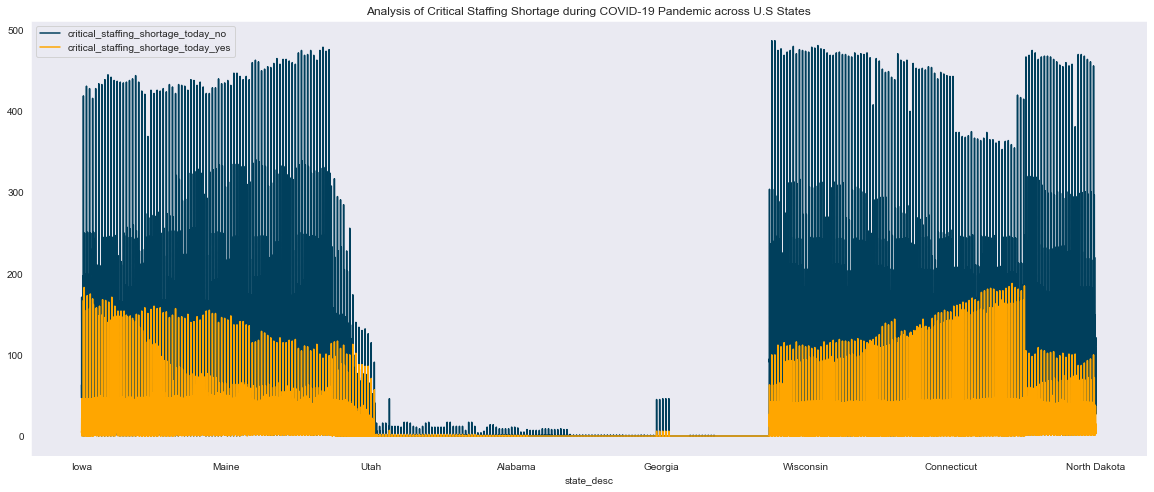

In [56]:
#Plotting Line Chart Visualization

covid_dataframe.head()
plt.rcParams['figure.figsize'] = (20, 8)
covid_dataframe.plot(x="state_desc", y=["critical_staffing_shortage_today_no","critical_staffing_shortage_today_yes"], color=['#003f5c','#ffa600'])
plt.title('Analysis of Critical Staffing Shortage during COVID-19 Pandemic across U.S States')
plt.show()    


The above graph depicts the contrast between the shortage of critical staff at hospital and facilities across U.S States. It is observed that at no point during COVID-19 pandemic there was a shortage of critical staff reported across hospitals in the United States.

In [57]:
#Map Visualization
#Preparing the dataframe to store the data for visualization for the latest date
print("Latest Record Date in the Dataset",max(covid_dataframe['date'])) #Output: datetime.date(2021, 3, 27)
print("Oldest Record Date in the Dataset",min(covid_dataframe['date'])) #Output: datetime.date(2020, 3, 3)
covid_map=covid_dataframe[covid_dataframe['date']==datetime.date(2021,3,27)]

Latest Record Date in the Dataset 2021-03-27
Oldest Record Date in the Dataset 2020-03-03


In [58]:
fig = px.density_mapbox(covid_map, lon='latitude', lat='longitude', z='inpatient_beds_utilization', radius=10,
                        center=dict(lat=39.9871347, lon=-98.778533), zoom=3,
                        mapbox_style="stamen-terrain")
fig.update_layout(title_text='Latest Update on Inpatient Bed Utilization across United States (As of 27th March, 2021)', title_x=0.5)
fig.show()

The map visualization above shows the inpatient beds utilization across different states of United States as of Latest Date i.e. 27th March 2021.


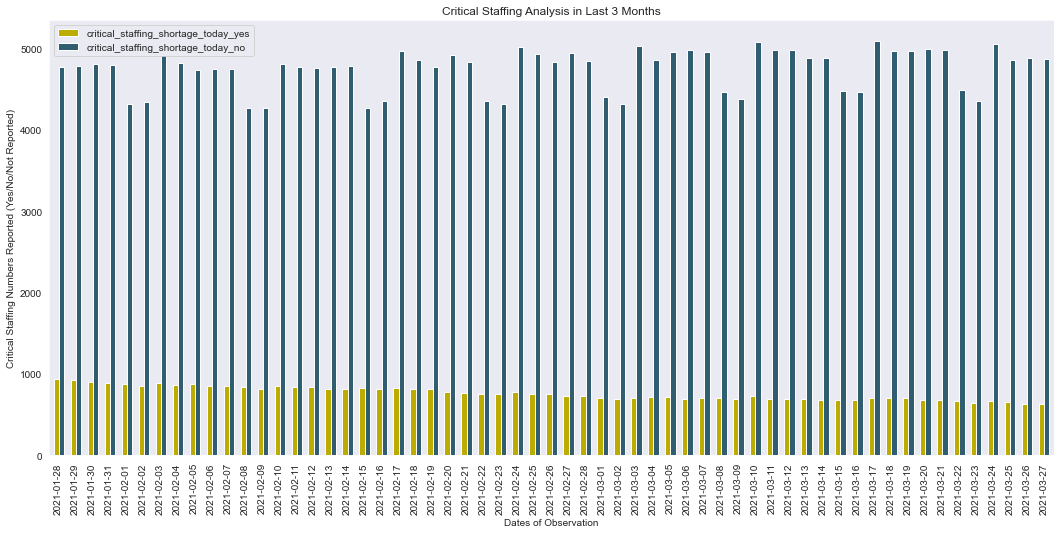

In [59]:
# Analysis of Critical Staffing Shortage in the last 3 months across States in the U.S
date_totals=covid_dataframe[covid_dataframe['date']>datetime.date(2021,1,27)].groupby('date', as_index=False).agg({"critical_staffing_shortage_today_yes": "sum","critical_staffing_shortage_today_no": "sum"})
p1 = date_totals.plot(x="date", y=["critical_staffing_shortage_today_yes","critical_staffing_shortage_today_no"], kind="bar",width=0.6, legend =True,  title="Critical Staffing Analysis in Last 3 Months" ,color=['#bcac00','#305d70'])
p1.set_xlabel("Dates of Observation")
p1.set_ylabel("Critical Staffing Numbers Reported (Yes/No/Not Reported)")
fig = plt.gcf()
fig.set_size_inches(18,8)

We can infer from the graph that there were no major scarce reported by hospitals in the United States observed in critical staff during the last 3 months.

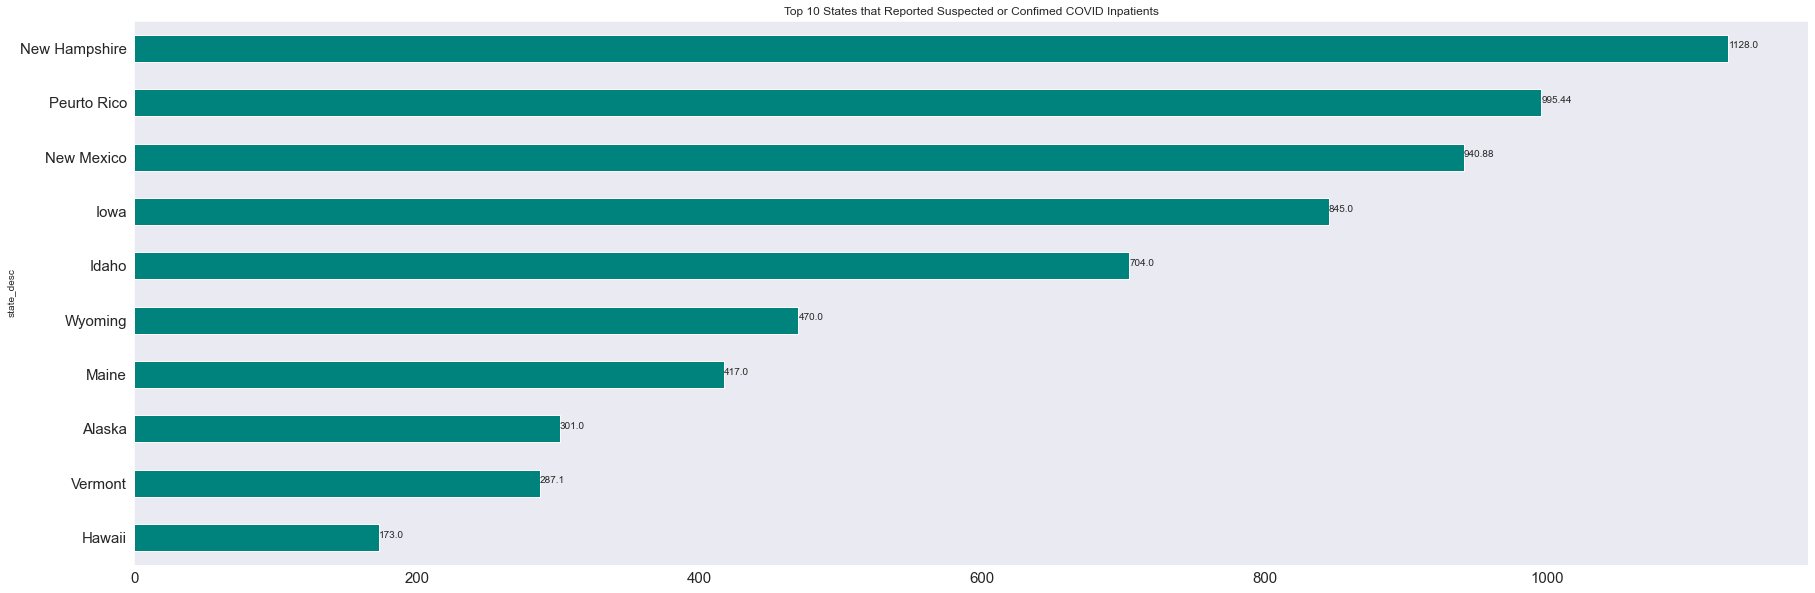

In [60]:
# Horizontal Bar Chart Visualization to analyse Top 10 states that have reported COVID confirmed or suspected inpatients
covid_onset_totals = covid_dataframe.groupby("state_desc")["hospital_onset_covid"].sum().sort_values().head(10)

plt.rcParams["figure.figsize"] = (30,10)
covid_onset_totals.plot(kind="barh", fontsize=15, title="Top 10 States that Reported Suspected or Confimed COVID Inpatients", color='#00827d')
for index, value in enumerate(covid_onset_totals):
    plt.text(value, index, str(round(value,2)))


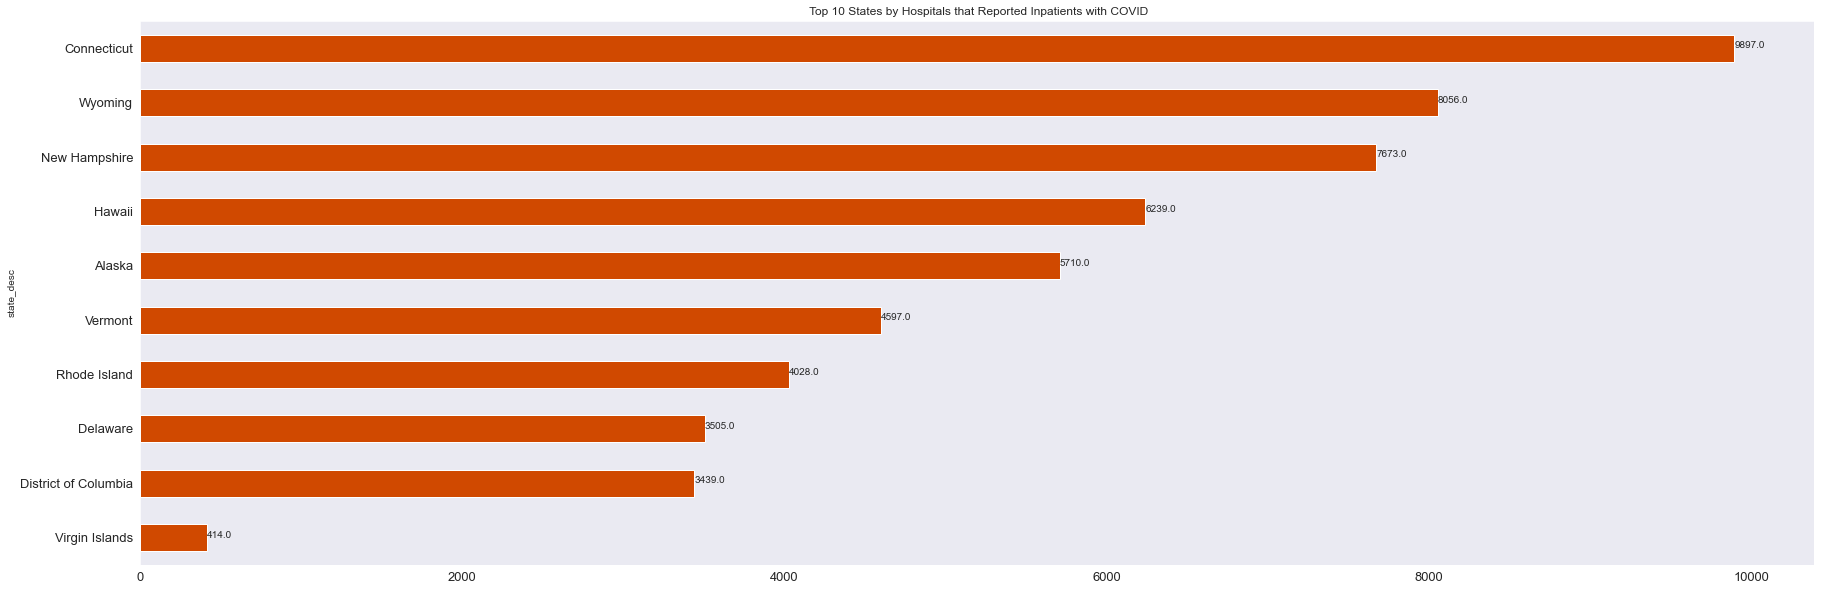

In [61]:
# Horizontal Bar Chart Visualization to analyse Top 10 states that have reported COVID confirmed inpatients
covid_onset_coverage_totals = covid_dataframe.groupby("state_desc")["hospital_onset_covid_coverage"].sum().sort_values().head(10)
covid_onset_coverage_totals.plot(kind="barh", fontsize=13, title=" Top 10 States by Hospitals that Reported Inpatients with COVID", color='#d04900')
for index, value in enumerate(covid_onset_coverage_totals):
    plt.text(value, index, str(round(value,2)))

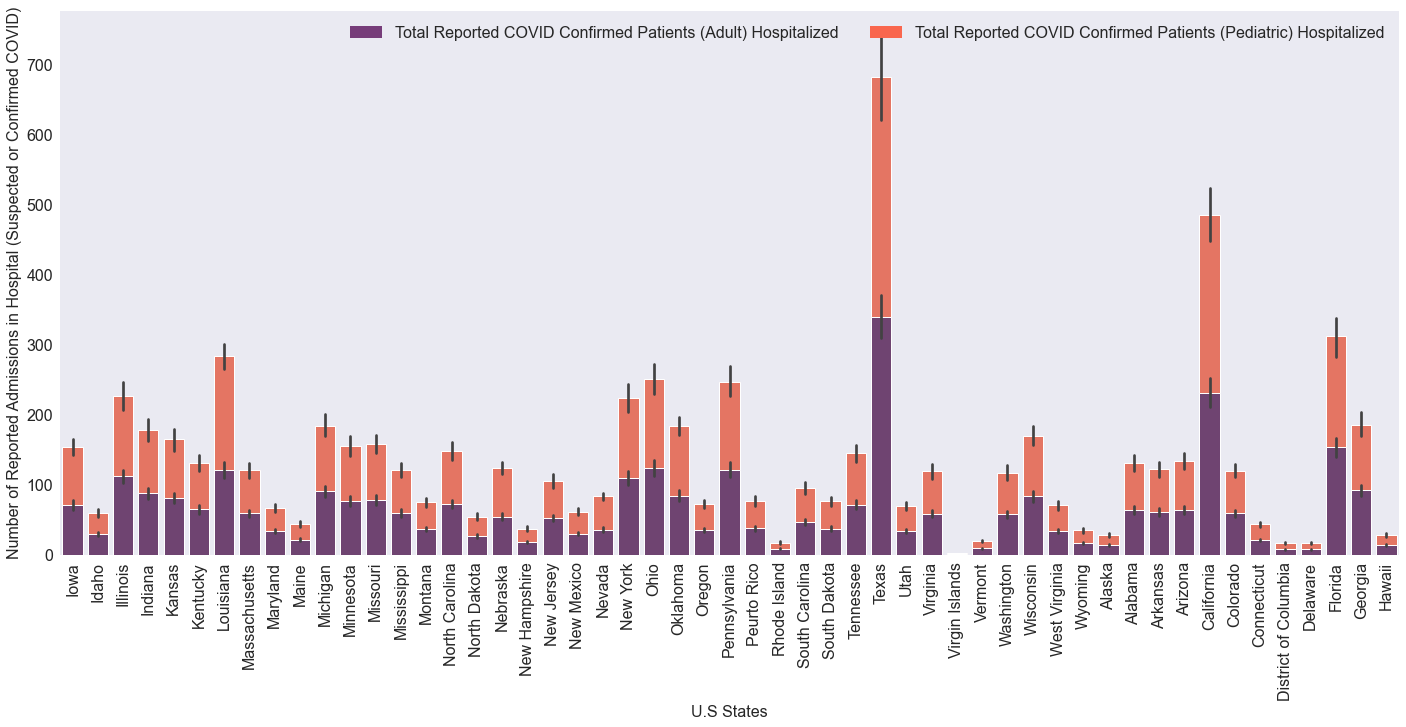

In [62]:

#Read in data & create total column
stacked_bar_data=covid_dataframe
stacked_bar_data["total"] = stacked_bar_data.total_adult_patients_hospitalized_confirmed_covid_coverage + stacked_bar_data.total_pediatric_patients_hospitalized_confirmed_covid_coverage

#Set general plot properties
sns.set_style("dark")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data.state_desc, y = stacked_bar_data.total, color = "#f9664e")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data.state_desc, y = stacked_bar_data.total_pediatric_patients_hospitalized_confirmed_covid_coverage, color = "#763c79")


topbar = plt.Rectangle((0,0),1,1,fc="#f9664e", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#763c79',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Total Reported COVID Confirmed Patients (Adult) Hospitalized', 'Total Reported COVID Confirmed Patients (Pediatric) Hospitalized'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Number of Reported Admissions in Hospital (Suspected or Confirmed COVID)")
bottom_plot.set_xlabel("U.S States")
bottom_plot.set_xticklabels(labels=stacked_bar_data['state_desc'].unique(),rotation=90)


#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)

The plot shows the bifurcation of patients belonging to Adult and Pediatric group who have been tested positive for COVID. We can infer from the graph that Texas state shows the largest number reported confirmed cases for both adult and pediatric groups.